# What's in this notebook
- LDA topic modelling on entire speech data set.
- (This was also run for the past ten years only in a separate notebook).
- Purpose: inclusion in correlations and prediction modelling to see if any relationships exist.
- No findings were strong so topic modelling was not ultimately used.

The below adapts process and code from the following instructors/tutorials:
- Megan Silvey: https://github.com/LinkedInLearning/build-three-real-world-python-applications-4379002/blob/main/Chapter%203/03_09b.ipynb
- Avkash Chauhan: https://github.com/prodramp/DeepWorks/tree/main/TopicModelling/BaseWorkshop

# Libraries

In [3]:
import gdown
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle
from IPython.display import display, HTML, IFrame

# Load data

In [5]:
# https://drive.google.com/file/d/1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD/view?usp=drive_link 
# Master Data set uk_speeches_cleaned_v2 13/05/25
file_id = '1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD'

# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file locally
output_path = 'uk_speeches_cleaned_v2_local.csv'
gdown.download(download_url, output_path, quiet=False)

# Read the downloaded CSV
uk_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\uk_speeches_cleaned_v2_local.csv
100%|██████████| 30.9M/30.9M [00:00<00:00, 73.6MB/s]


In [8]:
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   custom_ref  1365 non-null   object 
 1   reference   1200 non-null   object 
 2   country     1365 non-null   object 
 3   date        1365 non-null   object 
 4   title       1365 non-null   object 
 5   author      1365 non-null   object 
 6   is_gov      1365 non-null   float64
 7   text        1365 non-null   object 
dtypes: float64(1), object(7)
memory usage: 85.4+ KB


# Text prep

In [10]:
# Create a list of all text
speech_data = uk_data['text'].values.tolist()
type(speech_data)

list

In [12]:
'''Process text for topic modelling - create bigrams, remove stopwords, lowercase, tokenise, lemmatise.
Modified from https://github.com/LinkedInLearning/build-three-real-world-python-applications-4379002/blob/main/Chapter%203/03_09b.ipynb'''

def text_processing(texts):
    # Remove numbers and non-alphabetic characters
    texts = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]
    # Tokenize and lowercase
    texts = [[word for word in text.lower().split()] for text in texts]
    
    # Create and apply bigrams
    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    texts = [list(bigram_mod[text]) for text in texts]

    # Create and apply trigrams
    trigram = Phrases(bigram_mod[texts], min_count=5, threshold=100)
    trigram_mod = Phraser(trigram)
    texts = [list(trigram_mod[doc]) for doc in texts]
    # Lemmatization
    lmtzr = WordNetLemmatizer()
    texts = [[lmtzr.lemmatize(word) for word in text] for text in texts]
    # Remove stopwords
    stoplist = stopwords.words('english')
    texts = [[word for word in text if word not in stoplist] for text in texts]
    # Remove short words
    texts = [[word for word in tokens if len(word) >= 3] for tokens in texts]
    return texts

In [14]:
# Apply pre-processing function to text data
speech_data = text_processing(speech_data)

In [15]:
# Convert to dictionary
dictionary = Dictionary(speech_data)
len(dictionary)

30016

In [16]:
# Create corpus for LDA analysis
corpus = [dictionary.doc2bow(text) for text in speech_data]
len(corpus)

1365

# Find optimal # topics
- Below are two methods (u_mass and c_v) used to find optimal number of topics (similar to the process for k-means clustering).
- As with k-means, it's a mix of art and science to find ideal number. The methods below provide guidance, but ultimately the model must be assessed for ease of interpretation and a practical number of topics to work with.

In [18]:
print(type(speech_data))
print(speech_data[0][:10])  # Show first 10 tokens of the first document

<class 'list'>
['thank_you', 'chairman', 'actually', 'pleased', 'opportunity', 'respond', 'directly', 'serious', 'concern', 'expressed']


In [19]:
# Find optimal number of topics (k) - u_mass method
np.random.seed(42)
k_range = range(5,20)
scores = []

for k in k_range:
    lda_model = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                  num_topics=k, passes=20,
                                  random_state=42)
    cm = CoherenceModel(model=lda_model, corpus=corpus, 
                        dictionary=dictionary, coherence='u_mass')
    print(cm.get_coherence())
    scores.append(cm.get_coherence())

-0.2523903247540316
-0.2595592095826132
-0.2944318918516083
-0.2924729321081728
-0.32418280474464534
-0.4158607013388672
-0.36061555625019004
-0.36880994002417317
-0.4469897785347096
-0.38379147494072424
-0.45553352754657145
-0.5068424599922322
-0.4086601086679571
-0.3958879106392381
-0.45826775070122955


C:\Users\katej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\katej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\katej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


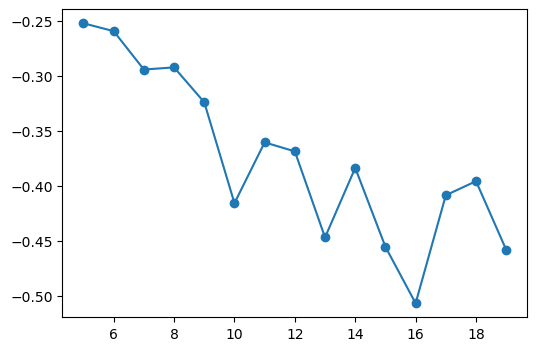

In [20]:
# Plot result
plt.figure(figsize=(6,4))
plt.plot(k_range, scores, marker='o')
plt.show()

**Note:** 
- With u_mass, we're looking for the lowest points in the above graph.
- 13, 16, and 18 seem to be the best number of topics according to this method.

In [22]:
# Find optimal number of topics (k) - c_v method
np.random.seed(42)
k_range = range(3,15)
scores = []

for k in k_range:
    lda_model2 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, 
                                  num_topics=k, passes=20,
                                  random_state=42)
    cm2 = CoherenceModel(model=lda_model2, corpus=corpus, 
                        dictionary=dictionary, texts=speech_data, coherence='c_v')
    print(cm2.get_coherence())
    scores.append(cm2.get_coherence())

0.3629661137707365
0.35961656583618984
0.3739791788331592
0.3740699548562117
0.38037864599490756
0.378709555987568
0.3688995794113353
0.37412892646581136
0.38209392332144226
0.3852918480003987
0.37979441340662234
0.3777887163592247


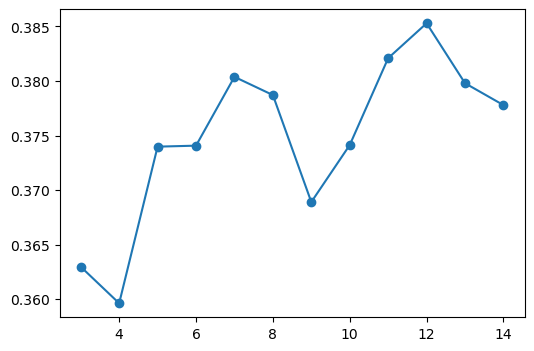

In [23]:
# Plot result
plt.figure(figsize=(6,4))
plt.plot(k_range, scores, marker='o')
plt.show()

**Note:** 
- With c_v, we're looking for the highest points in the above graph. This is technically 12, but this may be too many to be meaningful.
- c_v method looks at smaller passages/windows of text, vs. u_mass, which looks at document-level co-occurrence (i.e. just how many times words appear in the entire speech).
- Thus, c_v may be more appropriate for these texts; because speeches are quite long and cover a variety of topics, looking at words appearing more closely together (rather than words that are just in the same document generally) may form more cohesive topics.
- The difference in numbers above is small. I've gone with 8 for interpretability and to match our previous model (run before we had our final data set).

# Create models

In [198]:
# Create final LDA model
num_topics=8
model = ldamodel.LdaModel(corpus, id2word=dictionary, 
                          num_topics=num_topics, passes=20,
                          iterations=500, random_state=42)

In [199]:
# View result
# model.show_topics()

# Show topics in a readable format
topic_keywords = {}
for topic_id, topic in model.show_topics(num_topics, num_words=20, formatted=False):
    words = [word for word, prob in topic]
    topic_keywords[topic_id] = words
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: financial, bank, risk, policy, stability, system, firm, market, data, also, need, service, committee, fpc, work, objective, new, approach, important, time
Topic 1: risk, financial, bank, capital, asset, market, crisis, debt, credit, price, economy, equity, year, would, rate, policy, one, system, investment, may
Topic 2: note, banknote, internal_audit, turing, internal_auditor, design, polymer, character, machine, science, turner, security_features, feature, work, contribution, bvar, computer, new, image, jane_austen
Topic 3: inflation, forecast, model, policy, bank, rate, uncertainty, data, growth, shock, chart, mpc, show, interest, expectation, market, one, different, time, path
Topic 4: bank, risk, firm, financial, system, would, new, market, need, one, also, capital, year, time, payment, banking, change, insurance, central, resolution
Topic 5: market, bank, liquidity, financial, asset, risk, rate, central, reserve, term, system, fund, bond, lending, money, collateral, also,

In [202]:
# Enable visualisation in this notebook
pyLDAvis.enable_notebook()

# Create filename
model_name = f"LDAvis_alltime_cleaned_1505_{num_topics}"
pickle_path = f"{model_name}.pkl"
html_path = f"{model_name}.html"

# Print names
print(f"Model name: {model_name}")
print(f"Pickle file: {pickle_path}")
print(f"HTML file: {html_path}")

Model name: LDAvis_alltime_cleaned_1505_8
Pickle file: LDAvis_alltime_cleaned_1505_8.pkl
HTML file: LDAvis_alltime_cleaned_1505_8.html


In [204]:
# Save directory
save_dir = "LDA models"
os.makedirs(save_dir, exist_ok=True)

In [206]:
# Full paths
pickle_full_path = os.path.join(save_dir, pickle_path)
html_full_path = os.path.join(save_dir, html_path)

# Check paths
print(f"Saving to: {pickle_full_path} and {html_full_path}")

Saving to: LDA models\LDAvis_alltime_cleaned_1505_8.pkl and LDA models\LDAvis_alltime_cleaned_1505_8.html


In [208]:
# Prepare file data
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)

In [209]:
# Save pyLDAvis data
with open(pickle_full_path, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [210]:
# Save html of model
pyLDAvis.save_html(LDAvis_prepared, html_full_path)

In [211]:
# View final model in notebook
display(pyLDAvis.display(LDAvis_prepared))

**A guide on how to use this visualisation:**
- Click on a topic to explore it.
- **Size of circle** represents prevalance of each topic across all speeches. (You can also see a % figure of how prevalent the topic is above the bar graph when you click on it - e.g. Topic 1, the largest, is 30.7% of total topics.
- **Proximity of circles** represents how similar the topics are. You can see here that all the topics have fairly similar themes, except topic 3. (This is not unexpected for a specialised domain like central banking.)
- **Word bars:** blue bar shows how often the word appears across *all* topics; red bar shows how often the word appears in just *this* topic.
- **Relevance-metric slider** above the bars essentially adjusts between *frequency* and *uniqueness* of words in that topic: sliding to the right shows words that appear a lot in that topic generally; sliding left shows words that are more unique to *this specific* topic compared to the others. You will likely need to slide it more towards the left to pick out the core theme of the topic.

See more here: https://community.alteryx.com/t5/Data-Science/Getting-to-the-Point-with-Topic-Modeling-Part-3-Interpreting-the/ba-p/614992

**Important note on indexing:** Due to indexing differences in html and Python, the numbers in the vis and in the Python model are one off from each other (e.g. 'Financial Stability & Governance' topic is topic 0 in the actual model but 1 in the visualisation above, and so on).

# Apply topics to data frame

In [216]:
# Function to apply LDA topics to data frame
def get_topic_assignments(model, corpus, num_topics, doc_ids):
    
    # Create a list to store topic assignments
    topic_assignments = []
    
    # Get topic distribution for each speech
    for idx, doc in enumerate(corpus):
        doc_topics = model.get_document_topics(doc, minimum_probability=0)
        
        # Create a dictionary to store topic probabilities 
        doc_topic_dict = {f'topic_{i}': 0.0 for i in range(num_topics)}
        
        # Fill in probabilities
        for topic_id, prob in doc_topics:
            doc_topic_dict[f'topic_{topic_id}'] = prob
            
        # Add dominant topic
        dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
        doc_topic_dict['dominant_topic'] = dominant_topic
        doc_topic_dict['custom_ref'] = doc_ids[idx]  # Use custom_ref instead of document_index
        
        topic_assignments.append(doc_topic_dict)
    
    return pd.DataFrame(topic_assignments)

In [218]:
# Get topic assignments
topic_df = get_topic_assignments(model, corpus, num_topics, uk_data['custom_ref'])

In [219]:
# Merge dataframes
uk_data_with_topics = uk_data.merge(topic_df, on='custom_ref', how='left')

In [220]:
# Check result
print(uk_data_with_topics.shape)
uk_data_with_topics.head()

(1365, 17)


,custom_ref,reference,country,date,title,author,is_gov,text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,dominant_topic
0,UK_1998-09-15_George,r980915a_BOE,UK,1998-09-15,Speech,Edward George,1.0,"Thank you, Chairman. I'm actually very pleased...",0.019365,0.000115,0.000115,0.000115,0.016494,0.000115,0.000115,0.963565,7
1,UK_1998-10-21_George,r981021b_BOE,UK,1998-10-21,Britain in Europe,Edward George,1.0,It's a great pleasure to be here in the beauti...,0.397453,0.031454,0.000063,0.000063,0.000063,0.000063,0.000063,0.570779,7
2,UK_1998-10-21_King,r981021a_BOE,UK,1998-10-21,Impact of the recent turbulence in internation...,Mervyn King,0.0,Few industries have suffered more from volatil...,0.000108,0.209397,0.000108,0.000108,0.000108,0.044162,0.028020,0.717988,7
3,UK_1998-11-01_budd,r981101a_BOE,UK,1998-11-01,"Economic policy, with and without forecasts",budd,0.0,My topic this evening is the use of forecasts ...,0.113619,0.000056,0.000056,0.377057,0.186295,0.000056,0.037116,0.285746,3
4,UK_1998-11-01_vickers,r981101b_BOE,UK,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0.0,"Six years ago this week, sterling left the exc...",0.039526,0.000053,0.000053,0.245717,0.018334,0.000053,0.041993,0.654271,7


**Note:** I have named the topics below based on my own interpretation of the clusters shown in the html. Please explore/interrogate and bring your own interpretations; these names are subjective and they can be renamed if needs be!

In [246]:
# Rename topics
mapper = {0: 'Financial Stability & Governance', 
         1: 'Credit & Housing Markets',
         2: 'Currency & Audit',
         3: 'Forecasting & Uncertainty Modelling',
         4: 'Banking & Insurance Supervision',
         5: 'Liquidity & Asset Markets',
         6: 'Labour Markets & Productivity',
         7: 'Inflation & Monetary Policy'}

uk_data_with_topics['dominant_topic_name'] = uk_data_with_topics['dominant_topic'].map(mapper)

In [248]:
uk_data_with_topics.shape

(1365, 18)

In [250]:
uk_data_with_topics.head(3)

,custom_ref,reference,country,date,title,author,is_gov,text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,dominant_topic,dominant_topic_name
0,UK_1998-09-15_George,r980915a_BOE,UK,1998-09-15,Speech,Edward George,1.0,"Thank you, Chairman. I'm actually very pleased...",0.019365,0.000115,0.000115,0.000115,0.016494,0.000115,0.000115,0.963565,7,Inflation & Monetary Policy
1,UK_1998-10-21_George,r981021b_BOE,UK,1998-10-21,Britain in Europe,Edward George,1.0,It's a great pleasure to be here in the beauti...,0.397453,0.031454,0.000063,0.000063,0.000063,0.000063,0.000063,0.570779,7,Inflation & Monetary Policy
2,UK_1998-10-21_King,r981021a_BOE,UK,1998-10-21,Impact of the recent turbulence in internation...,Mervyn King,0.0,Few industries have suffered more from volatil...,0.000108,0.209397,0.000108,0.000108,0.000108,0.044162,0.028020,0.717988,7,Inflation & Monetary Policy


In [282]:
uk_data_with_topics.shape

(1365, 18)

In [413]:
uk_data_with_topics['dominant_topic_name'].value_counts(normalize=True)

dominant_topic_name
Inflation & Monetary Policy            0.346520
Banking & Insurance Supervision        0.281319
Credit & Housing Markets               0.112821
Financial Stability & Governance       0.103297
Labour Markets & Productivity          0.073993
Liquidity & Asset Markets              0.061538
Forecasting & Uncertainty Modelling    0.019048
Currency & Audit                       0.001465
Name: proportion, dtype: float64

**The above DataFrame now includes:**
- A score for each of the topics (higher score = topic is more prominent in that speech)
- Dominant topic in numeric form (dominant_topic)
- Dominant topic in name form (dominant_topic_name)

In [255]:
# Save as csv
uk_data_with_topics.to_csv('uk_data_with_topics.csv')

# Join with sentiment data

In [301]:
# Load CB RoBERTa
# https://drive.google.com/file/d/169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9/view?usp=drive_link
# agent_sentiment_pivot.csv
file_id = '169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'agent_sentiment_pivot_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
cbroberta = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\agent_sentiment_pivot_local.csv
100%|██████████| 30.9M/30.9M [00:00<00:00, 65.4MB/s]


In [302]:
# Load FinBERT data
# https://drive.google.com/file/d/1M1VYxNCNN-pKihEvZ-qCyQnaeJlprp6b/view?usp=drive_link
# uk_speeches_with_finbert_scores_v2
file_id = '1M1VYxNCNN-pKihEvZ-qCyQnaeJlprp6b'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'uk_speeches_with_finbert_scores_v2_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
finbert = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1M1VYxNCNN-pKihEvZ-qCyQnaeJlprp6b
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\uk_speeches_with_finbert_scores_v2_local.csv
100%|██████████| 30.9M/30.9M [00:00<00:00, 44.5MB/s]


In [357]:
# Merge finbert
fbert_subset = finbert[['custom_ref', 'finbert_score']]
topic_sentiment = uk_data_with_topics.merge(fbert_subset, on='custom_ref')

In [359]:
# Merge CB RoBERTa
cbroberta_subset = cbroberta[['custom_ref', 'cbroberta_avg_score']]
topic_sentiment = topic_sentiment.merge(cbroberta_subset, on='custom_ref')

In [361]:
# Subset cols
topic_sentiment = topic_sentiment.drop(['reference', 'country', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4',
       'topic_5', 'topic_6', 'topic_7'], axis=1)

In [368]:
#  Save to csv
topic_sentiment.to_csv('topic_sentiment.csv', index=False)

# Topic modelling and sentiment

In [393]:
# Function for correct x-axis display in timelines - PAST TEN YEARS

def year_format_pten(df, date_col=None, fontsize=12):
    ax = plt.gca()

    dates = df[date_col] if date_col else df.index
    datemin = dates.min().replace(month=1, day=1)
    datemax = dates.max().replace(month=1, day=1)

    ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Sent font size
    plt.xticks(fontsize=fontsize)

In [395]:
# Function to display events and focus areas on timelines - PAST TEN YEARS

def milestones_pten(ax=None, label_position=0.8):
    # Use current axis if none provided
    if ax is None:
        ax = plt.gca()
        
    y_max = ax.get_ylim()[1]
    y_min = ax.get_ylim()[0]
    
    # Calculate label position based on parameter
    label_y_position = y_min + (y_max - y_min) * label_position
    
    # Predefined highlight periods - only keeping those from 2015 onwards
    highlight_periods = {
        'COVID Pandemic\n(2020–2022)': ('2020', '2022')
        # ,
        # 'Geopolitical Tensions (2022-2025)': (2022, 2025)
    }
    
    # Predefined event lines - only keeping those from 2015 onwards
    event_lines = {
        'Brexit Referendum (2016)': '2016',
        'Brexit (2020)': '2020',
        'Supply Chain Crisis (2021)': '2021',
        'Ukraine Invasion. UK Mini-Budget (2022)': '2022',
    }
    
    # Add highlighted time periods
    for label, (start, end) in highlight_periods.items():
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        ax.axvspan(start_date, end_date, color='grey', alpha=0.2)
        # Use the adjustable position for labels
        ax.text((start_date + (end_date - start_date)/2), label_y_position, 
               label, ha='center', va='center', fontsize=9)
    
    # Add event lines
    for label, date in event_lines.items():
        event_date = pd.to_datetime(date)
        ax.axvline(event_date, color='black', linestyle='--', linewidth=0.8)
        ax.text(event_date, y_max*0.85, label, rotation=90, 
               va='top', ha='left', fontsize=12)

In [397]:
# Add gridlines to visualisations

def gridlines():
    plt.grid(True, linestyle='--', alpha=0.3)

### Topic sentiment over time

In [381]:
# Aggreagate by topic and date
topic_sentiment_agg = topic_sentiment.groupby(['dominant_topic_name', 'date'])[['finbert_score']].mean().reset_index()

# Convert to datetime
topic_sentiment_agg['date'] = pd.to_datetime(topic_sentiment_agg['date'])

# Make date index 
topic_sentiment_agg = topic_sentiment_agg.set_index('date')

,dominant_topic_name,finbert_score
date,,
1999-03-01,Banking & Insurance Supervision,0.059320
1999-05-25,Banking & Insurance Supervision,0.089614
1999-06-14,Banking & Insurance Supervision,0.034365
1999-06-17,Banking & Insurance Supervision,0.040708
1999-11-05,Banking & Insurance Supervision,-0.022267
...,...,...
2024-07-22,Liquidity & Asset Markets,0.069974
2024-12-02,Liquidity & Asset Markets,0.155953
2024-12-03,Liquidity & Asset Markets,0.101791


In [385]:
topic_sentiment_agg_pten = topic_sentiment_agg[topic_sentiment_agg.index >= '2015-01-01']
topic_sentiment_agg_pten.head()

,dominant_topic_name,finbert_score
date,,
2015-01-22,Banking & Insurance Supervision,0.139996
2015-01-29,Banking & Insurance Supervision,-0.029966
2015-02-24,Banking & Insurance Supervision,-0.346085
2015-02-26,Banking & Insurance Supervision,0.042828
2015-03-03,Banking & Insurance Supervision,0.256612


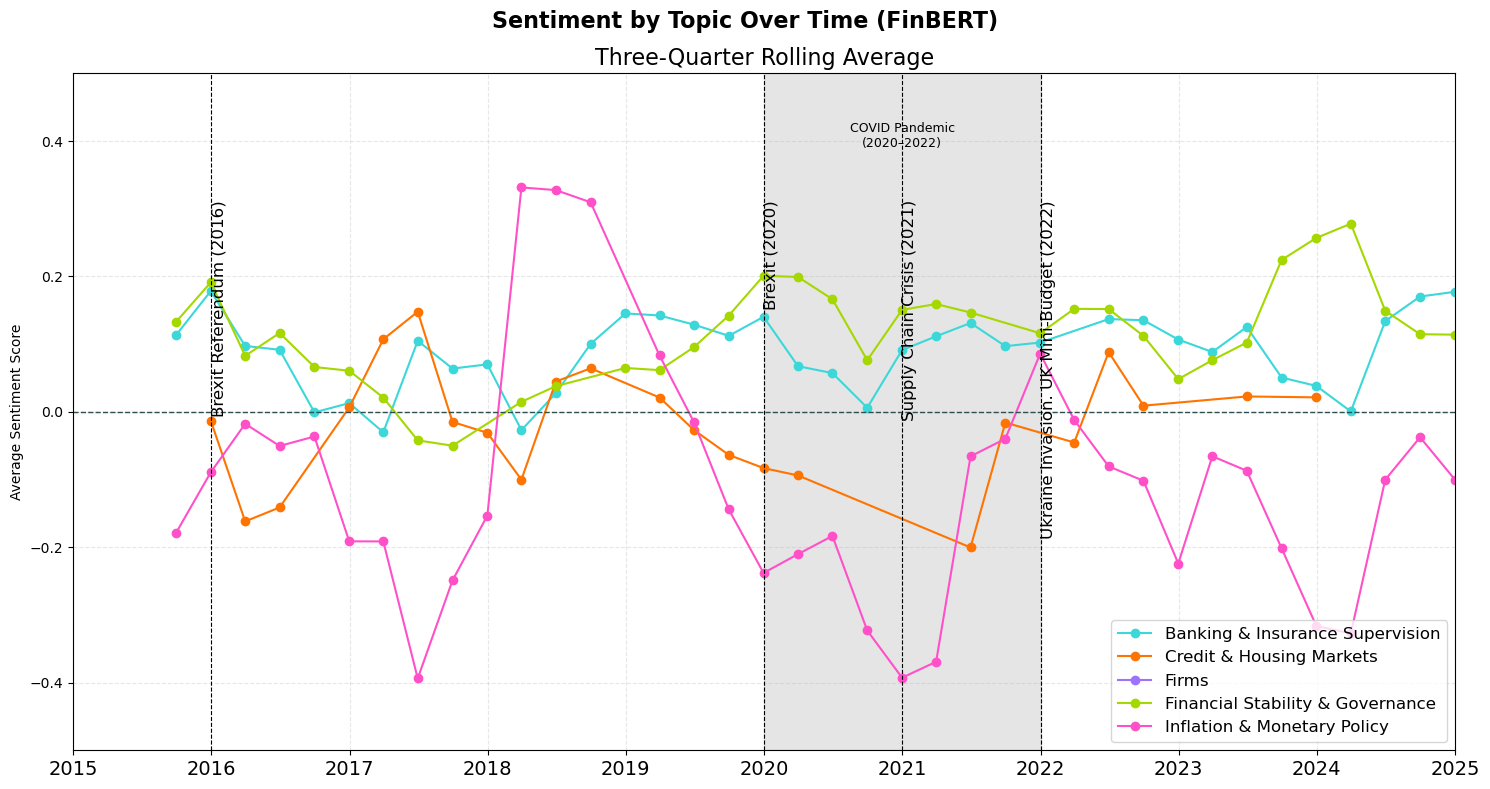

In [409]:
# Create dictionaries to store data
resample_data = {}
rolling_data = {}

# Define agent
topics = ['Banking & Insurance Supervision', 'Credit & Housing Markets',
       'Currency & Audit', 'Financial Stability & Governance',
       'Forecasting & Uncertainty Modelling',
       'Inflation & Monetary Policy', 'Labour Markets & Productivity',
       'Liquidity & Asset Markets']

for topic in topics:
    # Filter the DataFrame for just this topic
    topic_filter = topic_sentiment_agg_pten[topic_sentiment_agg_pten['dominant_topic_name'] == topic]
    
    # Resample
    resample = topic_filter['finbert_score'].resample('QE').mean().dropna()
    
    # Calculate rolling average
    rolling = resample.rolling(window=3, min_periods=3).mean()
    
    # Store in dictionaries
    resample_data[topic] = resample
    rolling_data[topic] = rolling

# Create plot
plt.figure(figsize=(15, 8))

# Plot each agent
plt.plot(rolling_data['Banking & Insurance Supervision'], label='Banking & Insurance Supervision', linewidth=1.5, color='#3CD7D9', marker='o')
plt.plot(rolling_data['Credit & Housing Markets'], label='Credit & Housing Markets', linewidth=1.5, color='#FF7300', marker='o')
plt.plot(rolling_data['Currency & Audit'], label='Firms', linewidth=1.5, color='#9E71FE', marker='o')
plt.plot(rolling_data['Financial Stability & Governance'], label='Financial Stability & Governance', linewidth=1.5, color='#A5D700', marker='o')
plt.plot(rolling_data['Inflation & Monetary Policy'], label='Inflation & Monetary Policy', linewidth=1.5, color='#FF50C8', marker='o')

# Add line at 0
plt.axhline(y=0, color='darkslategrey', linestyle='--', linewidth=1)

# Titles
plt.suptitle('Sentiment by Topic Over Time (FinBERT)', fontsize=16, weight='bold')
plt.title('Three-Quarter Rolling Average', fontsize=16)
plt.ylabel('Average Sentiment Score')
gridlines()
year_format_pten(topic_sentiment_agg_pten, fontsize=14)
milestones_pten(label_position=1.05)
plt.ylim(-0.5, 0.5)
plt.legend(loc='lower right', prop={'size':12})

plt.tight_layout()
plt.show()

In [421]:
# Pulling just speeches with the 'uncertainty' topic (topic 3)
uncertainty = uk_data_with_topics.sort_values(by='topic_3', ascending=False).head(20)
uncertainty.shape

(20, 18)

In [9]:
# Save to csv
# uncertainty.to_csv('uncertainty_modelling.csv')